In [ ]:
!pip install underthesea
!pip install demoji
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 502.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 26.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/LDS0_K292_DATN_DS/Project1'

/content/gdrive/MyDrive/LDS0_K292_DATN_DS/Project1


# 1. Read data and overcheck

In [ ]:
file_name = "2_Reviews.csv"
data = pd.read_csv(file_name)

In [ ]:
data.head()

,ID,User,Time,Rating,Comment,IDRestaurant
0,1,PHAN LE,20/12/2023 21:13,5.2,"Gà chiên còn sống, rất tanh. Khủng khiép",1
1,2,Thúy,25/9/2023 15:43,5.0,"Đã ăn qua rồi, ăn ok ạ",1
2,3,Quyên Quyên,24/6/2023 11:11,5.0,Đã thư rất ngon,1
3,4,Phương Thảo,22/12/2022 14:58,1.0,Tệ .. mua mang về cho 1 gói tương ớt. Và xin t...,1
4,5,Quỳnh Nguyễn,23/9/2022 22:40,4.2,"21h30...2 đứa nhỏ kêu đói, sau 1 hồi bình loạn...",1


In [ ]:
df = data[['Rating','Comment','IDRestaurant']]

In [ ]:
df['Comment'] = df.loc[:,'Comment'].astype('string')

<ipython-input-9-a8fcf66e4a4f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comment'] = df.loc[:,'Comment'].astype('string')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29959 entries, 0 to 29958
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rating        29959 non-null  float64
 1   Comment       29958 non-null  string 
 2   IDRestaurant  29959 non-null  int64  
dtypes: float64(1), int64(1), string(1)
memory usage: 702.3 KB


In [ ]:
df.dropna(inplace=True)

<ipython-input-11-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
df.isna().sum()

Rating          0
Comment         0
IDRestaurant    0
dtype: int64

# 2. Text Processing

## 2.1 Load text processing file

Load Emojcon

In [ ]:
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
  key, value = line.split('\t')
  emoji_dict[key] = str(value)
file.close()

Load Teencode

In [ ]:
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
  key, value = line.split('\t')
  teen_dict[key] = str(value)
file.close()

LOAD TRANSLATE ENGLISH -> VNMESE

In [ ]:
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
  key, value = line.split('\t')
  english_dict[key] = str(value)
file.close()

LOAD wrong words

In [ ]:
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()

LOAD STOPWORDS

In [ ]:
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

## 2.2 Text processing

In [ ]:
def process_text(text, emoji_dict, teen_dict, wrong_lst):
  document = text.lower()
  document = document.replace("’",'')
  document = regex.sub(r'\.+', ".", document)
  new_sentence =''
  for sentence in sent_tokenize(document):
    # if not(sentence.isascii()):###### CONVERT EMOJICON
    sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
    ###### CONVERT TEENCODE
    sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
    ###### DEL Punctuation & Numbers
    pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
    sentence = ' '.join(regex.findall(pattern,sentence))
    # ...
    ###### DEL wrong words
    sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
    new_sentence = new_sentence+ sentence + '. '
  document = new_sentence
  #print(document)
  ###### DEL excess blank space
  document = regex.sub(r'\s+', ' ', document).strip()
  #...
  return document

In [ ]:
df['Comment_processed'] = df.loc[:,'Comment'].apply(lambda row: process_text(row, emoji_dict, teen_dict, wrong_lst))

<ipython-input-19-c95600ddb6d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comment_processed'] = df.loc[:,'Comment'].apply(lambda row: process_text(row, emoji_dict, teen_dict, wrong_lst))


In [ ]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [ ]:
df.dropna(inplace=True)

<ipython-input-21-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
df.isna().sum()

Rating               0
Comment              0
IDRestaurant         0
Comment_processed    0
dtype: int64

In [ ]:
df['Comment_processed'] = df['Comment_processed'].apply(lambda row: covert_unicode(row))

<ipython-input-23-dc785783c9b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comment_processed'] = df['Comment_processed'].apply(lambda row: covert_unicode(row))


In [ ]:
def process_special_word(text):
# có thể có nhiều từ đặc biệt cần ráp lại với nhau
  new_text = ''
  text_lst = text.split()
  i= 0
  # không, chẳng, chả...
  if 'không' in text_lst:
    while i <= len(text_lst) - 1:
      word = text_lst[i]
      #print(word)
      #print(i)
      if word == 'không':
        next_idx = i+1
        if next_idx <= len(text_lst) -1:
          word = word +'_'+ text_lst[next_idx]
        i= next_idx + 1
      else:
        i = i+1
      new_text = new_text + word + ' '
  else:
    new_text = text
  return new_text.strip()

In [ ]:
df['Comment_processed'] = df['Comment_processed'].apply(lambda row: process_special_word(row))

<ipython-input-25-28a412c30593>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comment_processed'] = df['Comment_processed'].apply(lambda row: process_special_word(row))


In [ ]:
import re
# Hàm để chuẩn hóa các từ có ký tự lặp
def normalize_repeated_characters(text):
  # Thay thế mọi ký tự lặp liên tiếp bằng một ký tự đó
  # Ví dụ: "ngonnnn" thành "ngon", "thiệtttt" thành "thiệt"
  return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
df['Comment_processed'] = df['Comment_processed'].apply(lambda row: normalize_repeated_characters(row))

<ipython-input-27-f7cf7424be69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comment_processed'] = df['Comment_processed'].apply(lambda row: normalize_repeated_characters(row))


In [ ]:
def remove_stopword(text, stopwords):
  ###### REMOVE stop words
  document = ' '.join('' if word in stopwords else word for word in text.split())
  #print(document)
  ###### DEL excess blank space
  document = regex.sub(r'\s+', ' ', document).strip()
  return document

In [ ]:
df['Comment_processed'] = df['Comment_processed'].apply(lambda row: remove_stopword(row,stopwords_lst))

<ipython-input-29-3d224e704463>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comment_processed'] = df['Comment_processed'].apply(lambda row: remove_stopword(row,stopwords_lst))


In [ ]:
df.head()

,Rating,Comment,IDRestaurant,Comment_processed
0,5.2,"Gà chiên còn sống, rất tanh. Khủng khiép",1,gà chiên sống . khủng khiép.
1,5.0,"Đã ăn qua rồi, ăn ok ạ",1,ạ.
2,5.0,Đã thư rất ngon,1,thư .
3,1.0,Tệ .. mua mang về cho 1 gói tương ớt. Và xin t...,1,tệ. gói tương ớt. không_được. tương . tương. m...
4,4.2,"21h30...2 đứa nhỏ kêu đói, sau 1 hồi bình loạn...",1,đứa kêu đói hồi bình loạn chốt . háo hức đứa n...


In [ ]:
df['RatingFilter'] = df['Rating'].apply(lambda x: ('below3' if x <= 3 else '3to5' if x <=5 else '5to7' if x <=7 else 'above7'))

<ipython-input-31-5c7e22ed1ac7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RatingFilter'] = df['Rating'].apply(lambda x: ('below3' if x <= 3 else '3to5' if x <=5 else '5to7' if x <=7 else 'above7'))


In [ ]:
aggregations = {
    'RatingFilter': lambda x: ' '.join(x),                    # Sum of scores
    'Comment_processed': lambda x: ' '.join(x)   # Join players' names
}

In [ ]:
df_rank = df.groupby('IDRestaurant').agg(aggregations).reset_index()

In [ ]:
df_rank.head()

,IDRestaurant,RatingFilter,Comment_processed
0,1,5to7 3to5 3to5 below3 3to5 above7 below3 above...,gà chiên sống . khủng khiép. ạ. thư . tệ. gói ...
1,2,5to7,bệnh vị cháo thịt bằm miệng bớt lạt lẽo. cháo ...
2,3,below3 below3 3to5 below3 above7 above7 above7...,thời chuẩn tiếng thiệt công quán. không_rảnh k...
3,4,below3 below3 below3 below3 3to5 above7 5to7 b...,không_hiểu trình nấu nướng thể quán giá không_...
4,5,3to5 3to5 below3 above7 above7 above7 5to7 abo...,bánh quẩy. quán quán. bánh thập cẩm thịt thúi ...


# 3. Modeling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# token_pattern = r"(?u)\b\d+(?:\.\d+)?\b"
vectorizer = TfidfVectorizer()

In [ ]:
scaled_data = vectorizer.fit_transform(df_rank['RatingFilter']).toarray()

In [ ]:
vectorizer.get_feature_names_out()

array(['3to5', '5to7', 'above7', 'below3'], dtype=object)

In [ ]:
scaled_df = pd.DataFrame(scaled_data, columns=vectorizer.get_feature_names_out())

In [ ]:
scaled_df.head()

,3to5,5to7,above7,below3
0,0.212671,0.336394,0.755634,0.520218
1,0.000000,1.000000,0.000000,0.000000
2,0.464785,0.371964,0.725895,0.344520
3,0.137852,0.272560,0.565148,0.766365
4,0.399906,0.197673,0.888056,0.111161


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X1 = scaled_df
inertia = []
for n in range(1 , 15):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=500,
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


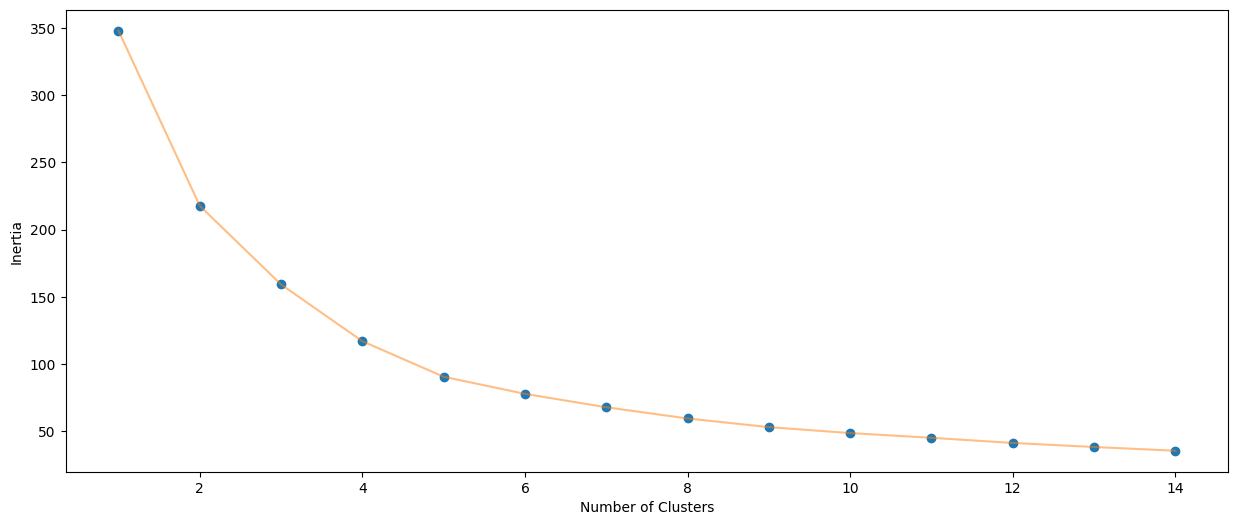

In [ ]:
import numpy as np
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 15) , inertia , 'o')
plt.plot(np.arange(1 , 15) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [ ]:
algorithm = (KMeans(n_clusters = 3 ,init='k-means++', n_init = 10 ,max_iter=1000,
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
y_kmeans = algorithm.fit_predict(scaled_df)
scaled_df['cluster'] = pd.DataFrame(y_kmeans)

In [ ]:
chart1 = scaled_df[scaled_df['cluster'] == 0]

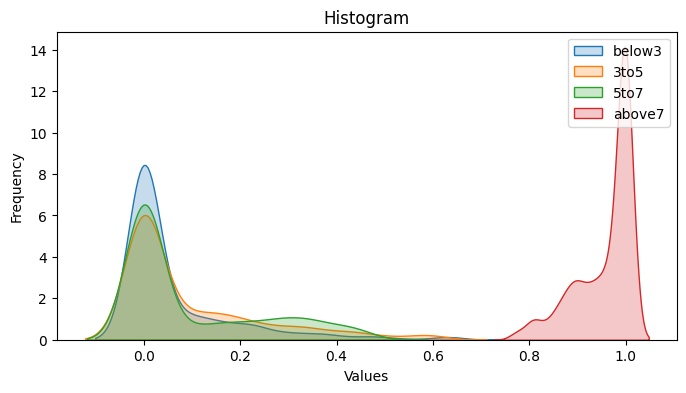

In [ ]:
plt.figure(figsize=(8, 4))
sn.kdeplot(chart1['below3'], fill=True, label = 'below3')
sn.kdeplot(chart1['3to5'], fill=True, label = '3to5')
sn.kdeplot(chart1['5to7'], fill=True, label = '5to7')
sn.kdeplot(chart1['above7'], fill=True, label = 'above7')
plt.legend()
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Giá trị rank dưới 7 xuất hiện khá thấp, còn trên 7 xuất hiện khá nhiều cho thấy những nhà hàng này là nhà hàng chất lượng cao

In [ ]:
chart2 = scaled_df[scaled_df['cluster'] == 1]

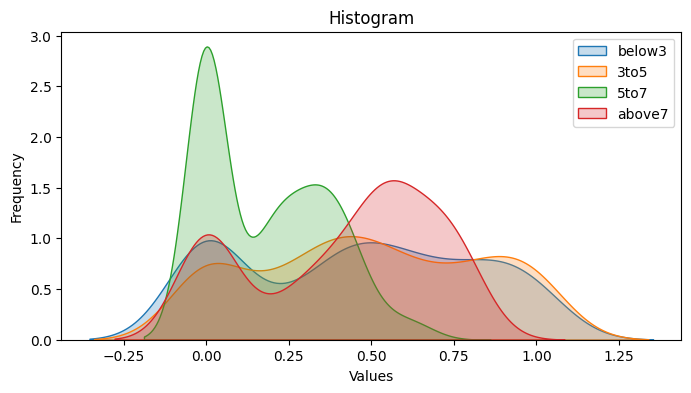

In [ ]:
plt.figure(figsize=(8, 4))
sn.kdeplot(chart2['below3'], fill=True, label = 'below3')
sn.kdeplot(chart2['3to5'], fill=True, label = '3to5')
sn.kdeplot(chart2['5to7'], fill=True, label = '5to7')
sn.kdeplot(chart2['above7'], fill=True, label = 'above7')
plt.legend()
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Các giá trị rank dưới 5 xuất hiện khá nhiều, điều này thể hiện đây là những nhà hàng có chất lượng thấp, cần cải thiện

In [ ]:
chart3 = scaled_df[scaled_df['cluster'] == 2]

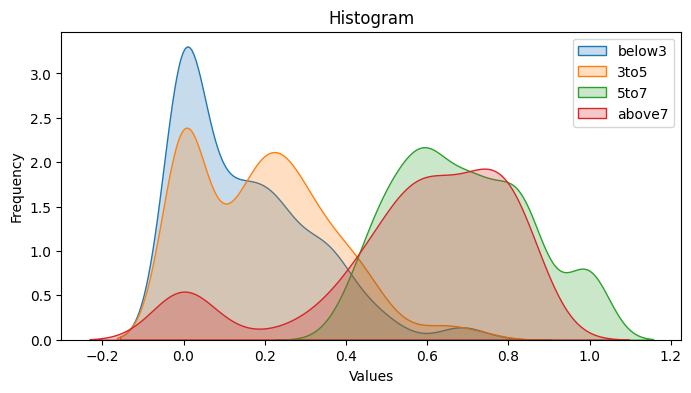

In [ ]:
plt.figure(figsize=(8, 4))
sn.kdeplot(chart3['below3'], fill=True, label = 'below3')
sn.kdeplot(chart3['3to5'], fill=True, label = '3to5')
sn.kdeplot(chart3['5to7'], fill=True, label = '5to7')
sn.kdeplot(chart3['above7'], fill=True, label = 'above7')
plt.legend()
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Các giá trị rank xuất hiện khá đồng đều, đây sẽ là những nhà hàng có chất lượng trung bình

In [ ]:
df_rank['cluster'] = pd.DataFrame(y_kmeans)

In [ ]:
df_rank.head()

,IDRestaurant,RatingFilter,Comment_processed,cluster
0,1,5to7 3to5 3to5 below3 3to5 above7 below3 above...,gà chiên sống . khủng khiép. ạ. thư . tệ. gói ...,1
1,2,5to7,bệnh vị cháo thịt bằm miệng bớt lạt lẽo. cháo ...,2
2,3,below3 below3 3to5 below3 above7 above7 above7...,thời chuẩn tiếng thiệt công quán. không_rảnh k...,1
3,4,below3 below3 below3 below3 3to5 above7 5to7 b...,không_hiểu trình nấu nướng thể quán giá không_...,1
4,5,3to5 3to5 below3 above7 above7 above7 5to7 abo...,bánh quẩy. quán quán. bánh thập cẩm thịt thúi ...,0


In [ ]:
df_rank['cluster'].value_counts()

0    646
2    300
1    228
Name: cluster, dtype: int64

In [ ]:
df_rank['cluster'] = df_rank['cluster'].apply(lambda x: ('Chất lượng tốt' if x == 0 else 'Chất lượng trung bình' if x ==1 else 'Chất lượng thấp'))

In [ ]:
df_rank.head()

,IDRestaurant,RatingFilter,Comment_processed,cluster
0,1,5to7 3to5 3to5 below3 3to5 above7 below3 above...,gà chiên sống . khủng khiép. ạ. thư . tệ. gói ...,Chất lượng trung bình
1,2,5to7,bệnh vị cháo thịt bằm miệng bớt lạt lẽo. cháo ...,Chất lượng thấp
2,3,below3 below3 3to5 below3 above7 above7 above7...,thời chuẩn tiếng thiệt công quán. không_rảnh k...,Chất lượng trung bình
3,4,below3 below3 below3 below3 3to5 above7 5to7 b...,không_hiểu trình nấu nướng thể quán giá không_...,Chất lượng trung bình
4,5,3to5 3to5 below3 above7 above7 above7 5to7 abo...,bánh quẩy. quán quán. bánh thập cẩm thịt thúi ...,Chất lượng tốt


In [ ]:
df_rank = df_rank.rename(columns={'IDRestaurant': 'ID'})

# 4. Visualization

In [ ]:
file_name = "1_Restaurants.csv"
data_ = pd.read_csv(file_name)

In [ ]:
data_.tail()

,ID,Restaurant,Address,Time,Price,District
1617,1618,Món Ăn Miền Trung - Thắng Lợi,"180/1C Tô Ký - Khu Phố 2, P. Tân Chánh Hiệp, Q...",NaN,19.000 - 79.000,Quận 12
1618,1619,Bánh Mì Bò Nướng Cô Ba - Hiệp Thành 17,"284 Hiệp Thành 17, P. Hiệp Thành, Quận 12, TP....",05:30 - 21:00,0 - 0,Quận 12
1619,1620,Anh Anh Quán - Cơm Tấm Sườn Ốp La & Bún Thịt N...,"89 Trương Thị Hoa, P. Tân Thới Hiệp, Quận 12, ...",NaN,30.000 - 36.000,Quận 12
1620,1621,Phú Mập - Cháo Lòng - Lê Văn Khương,"756 Lê Văn Khương, P. Thới An, Quận 12, TP. HCM",NaN,0 - 0,Quận 12
1621,1622,长鲍鱼 Trường Bào Ngư - Súp Bào Ngư Vi Cá Tẩm Bổ ...,"290/30/06 HT17, P. Hiệp Thành, Quận 12, TP. HCM",07:30 - 21:30,0 - 0,Quận 12


In [ ]:
data_merged = pd.merge(data_, df_rank, on='ID', how='inner')

In [ ]:
data_merged.head()

,ID,Restaurant,Address,Time,Price,District,RatingFilter,Comment_processed,cluster
0,1,Gà Rán & Burger McDonald's Đa Kao,"2 - 6 Bis Điện Biên Phủ, Quận 1, TP. HCM",00:00 - 23:59,50.000 - 200.000,Quận 1,5to7 3to5 3to5 below3 3to5 above7 below3 above...,gà chiên sống . khủng khiép. ạ. thư . tệ. gói ...,Chất lượng trung bình
1,2,Cháo Trắng - Cháo Thịt Bằm BK House - Phạm Viế...,"112B Phạm Viết Chánh, P. Nguyễn Cư Trinh, Quận...",00:00 - 23:59,5.000 - 40.000,Quận 1,5to7,bệnh vị cháo thịt bằm miệng bớt lạt lẽo. cháo ...,Chất lượng thấp
2,3,Texas Chicken - Nguyễn Thái Học,"115 Nguyễn Thái Học , Quận 1, TP. HCM",NaN,30.000 - 300.000,Quận 1,below3 below3 3to5 below3 above7 above7 above7...,thời chuẩn tiếng thiệt công quán. không_rảnh k...,Chất lượng trung bình
3,4,Bếp Chay 365,"Tầng 1, 35 Nguyễn Văn Tráng, P. Bến Thành, Quậ...",NaN,15.000 - 50.000,Quận 1,below3 below3 below3 below3 3to5 above7 5to7 b...,không_hiểu trình nấu nướng thể quán giá không_...,Chất lượng trung bình
4,5,Bánh Canh Cua Linh,"80A Điện Biên Phủ, P. Đa Kao, Quận 1, TP. HCM",06:20 - 22:00,25.000 - 35.000,Quận 1,3to5 3to5 below3 above7 above7 above7 5to7 abo...,bánh quẩy. quán quán. bánh thập cẩm thịt thúi ...,Chất lượng tốt


In [ ]:
def findcomment(id):
  max_row_index = data[data['IDRestaurant'] == id]['Rating'].idxmax()
  comment_maxrank = data.loc[max_row_index]['Comment']
  max_rank = data.loc[max_row_index]['Rating']

  min_row_index = data[data['IDRestaurant'] == id]['Rating'].idxmin()
  comment_minrank = data.loc[min_row_index]['Comment']
  min_rank = data.loc[min_row_index]['Rating']

  return comment_minrank, comment_maxrank, min_rank, max_rank

In [ ]:
from wordcloud import WordCloud

In [ ]:
def Select_id(id):
  name = data_merged[data_merged['ID'] == id]['Restaurant'].iloc[0]
  address = data_merged[data_merged['ID'] == id]['Address'].iloc[0]
  open_close_time = data_merged[data_merged['ID'] == id]['Time'].iloc[0]
  giatien = data_merged[data_merged['ID'] == id]['Price'].iloc[0]

  print('Tên nhà hàng: ',name)
  print('Địa chỉ: ',address)
  print('Thời gian mở cửa: ',open_close_time)
  print('Giá tiền: ',giatien)

  chart1 = data[data['IDRestaurant'] == id]['Rating']
  print('Phân phối của xếp hạng nhà hàng: \n')

  plt.figure(figsize=(8, 4))
  sn.histplot(chart1, kde=True, bins=10, color='skyblue', edgecolor='black')
  plt.title('Histogram')
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.show()

  cmt_min,cmt_max, min_rank, max_rank = findcomment(id)
  print('\nReview có điểm rank cao nhất: ',max_rank,'\n', cmt_max)
  print('\nReview có điểm rank thấp nhất: ',min_rank,'\n', cmt_min)

  nhom = data_merged[data_merged['ID'] == id]['cluster'].iloc[0]
  print('\nNhóm nhà hàng được phân loại: ',nhom)

  cmt_process = data_merged[data_merged['ID'] == id]['Comment_processed'].iloc[0]
  wc_like=WordCloud(
          background_color='black',
          max_words=500)
  wc_like.generate(cmt_process)

  print('\nNội dung chính trong các comment trong review: \n')
  plt.figure(figsize=(12,12))
  plt.imshow(wc_like,interpolation='bilinear')
  plt.axis('off')
  plt.show()


Tên nhà hàng:  Út Hương - Cơm & Món Xào
Địa chỉ:  TK18/1 Nguyễn Cảnh Chân, P. Cầu Kho, Quận 1, TP. HCM
Thời gian mở cửa:  nan
Giá tiền:  35.000 - 220.000
Phân phối của xếp hạng nhà hàng: 



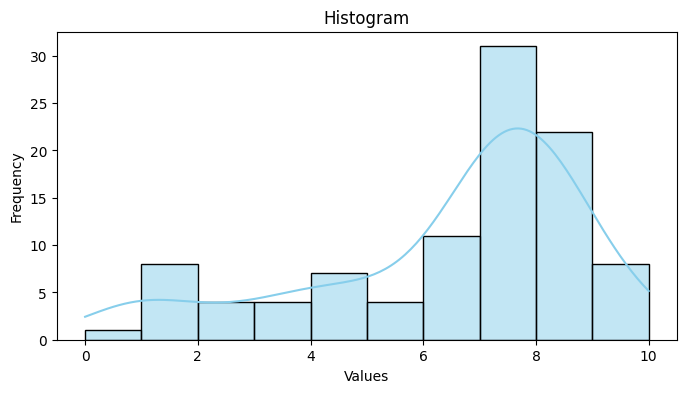


Review có điểm rank cao nhất:  10.0 
 - Thêm 1 địa chỉ ăn ngon bỏ túi của t :D
- Quán ngay mặt đường, có 2 quán 2 bên đường luôn
- Không gian rộng rãi, sạch sẽ
- Món ăn chất lượng, đáng tiền
- Nên đi nhiều người để gọi nhiều món ăn, món nào cũng ngon, thịt thà nhiều, ít dầu mỡ... keke
- Lần nào mình ghé ăn nhân viên cũng mời mọc súp cua nên ăn thử mà hok thích lắm, thích nhất món hủ tiếu xào hải sản 😬😬😬

Review có điểm rank thấp nhất:  0.0 
 Mình luôn lựa chọn cơm chiên dương châu bò bít tết mỗi lần ăn ở Út Hương. Giá cáo nhưng cực chất lượng. Ăn xong 1 hộp là no ná thở 

Hộp này mình ăn được hơn 1 nửa mới chụp, chứ không phải có bé tí vậy đâu, Cơm đầy full hộp, bò to nguyên miếng gần bằng cái hộp. Mềm và được ướp đậm đà. Kèm phần salad giấm ăn chung nữa.

Nhóm nhà hàng được phân loại:  Chất lượng tốt

Nội dung chính trong các comment trong review: 



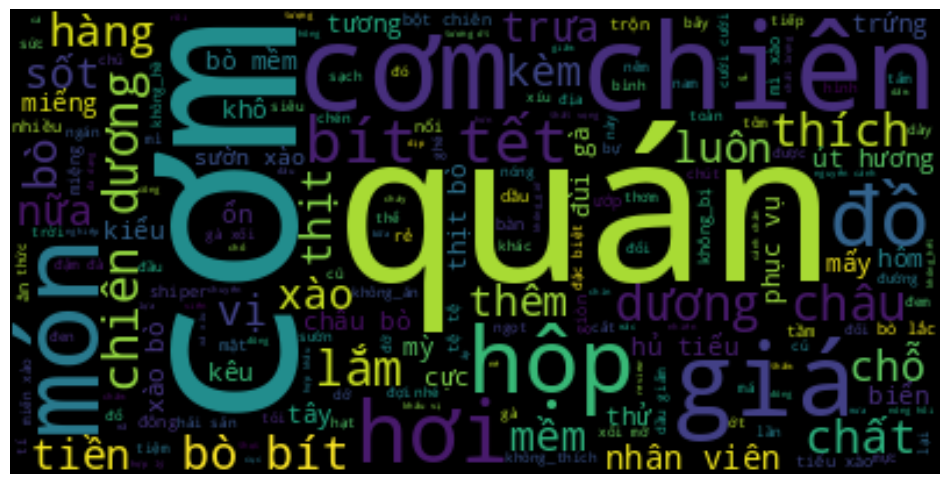

In [ ]:
Select_id(130)